# Experiment Environment for Adaptive access Control

This notebook focuses on experimentation with Machine learning models for Risk based Adaptive access Control.
First the Data is imported and explored, then the data is resampled to deal with data imbalance.
Visualizations on the distribution of the features in the data are presented to better understand the data.
After a good resampling strategy has been achieved, the resulting data is then used to train machine learning algorithms
These algorithms are also evaluated to judge performance based on AUCROC, Brier Score loss, F1 Score.
The results of the evaluations made are stored then used to make visualizations

In [1]:
# import required modules
# data wrangling and types modules
import pandas as pd
from pandas import DataFrame
from typing import Dict, List
from fractions import Fraction

# data resampling modules
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTEN
from collections import Counter

# metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, brier_score_loss
import time


# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
import catboost as cat

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns


## Importing Data and Data Exploration

This section deals with data imports and exploration.
The data is imported as a csv using pandas and converted to a pandas dataframe.
There are no null values within the dataset, there are 32769 entries in the dataset.
The distribution of access results, are Granted(1): 30872, Denied(0): 1897. 
This shows an imbalance in the dataset. The columns of the dataset all contain
integer values , but going by the dataset description, these integer values are
not real numbers but placeholders for categorical/identifying variables.


In [2]:
# import dataset
access_control_df = pd.read_csv('../datasets/access_control.csv')

access_control_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   user_context          32769 non-null  int64
 1   resource_sensitivity  32769 non-null  int64
 2   action_severity       32769 non-null  int64
 3   risk_history          32769 non-null  int64
 4   decision              32769 non-null  int64
dtypes: int64(5)
memory usage: 1.3 MB


In [3]:
# check class distribution
class_distribution = access_control_df['decision'].value_counts()

class_ratio = class_distribution[1]/class_distribution[0]

# determine the ratio of one class to another
Fraction(str(class_ratio)).limit_denominator(1)

Fraction(16, 1)

## Data Resampling

Before continuing with data exploration, due to the distribution of the data in this dataset; 16:1, for Access Granted versus Access denied, 
some resampling has to be done to make the data more balanced. This is done for various reasons, namely:
1. To improve the performance of the algorithm: when a machine learning model is trained on imbalanced data the 
experience of the model is usually skewed towards the majority class. In severe cases the model may not have any
discriminatory power concerning the minority class.
2. To make evaluation metrics more meaningful. When working with imbalanced datasets it is important to realise that
metrics such as accuracy, Mean Average Error can become misleading. The overwhelming nature of one class means that 
a model with 80% accuracy on a dataset with 8:1 distribution will be accurate on one class and have random behavior
on the minority class.
To resample a dataset, oversampling or undersampling can be used
Describe Oversampling and UnderSampling
Using an combination of the two here SMOTE and ENN(Edited Nearest Neighbors)

### Data Resampling Experimentation
We first train a model (decision model) on the data with it's current imbalance and record the Brier score loss. We then resample the data using SMOTEENN, which combines SMOTEN, which is SMOTE for categorical features and ENN which does undersampling

In [4]:
# split data
X = access_control_df.drop(columns='decision', axis=1)
y = access_control_df['decision']

# train and test splits
train_X, Val_X, train_y, val_y = train_test_split(X, y, random_state=46, stratify=y)

# train, predict, and record brier score loss
decision_tree_model = DecisionTreeClassifier(random_state=46)
decision_tree_model.fit (train_X, train_y)
model_predictions = decision_tree_model.predict(Val_X)
brier_score_loss(val_y, model_predictions )

0.08043451727084096

In [5]:
# define resampling method
resample = SMOTEENN(smote=SMOTEN(sampling_strategy='minority'), enn=EditedNearestNeighbours(sampling_strategy='all', kind_sel="mode"), random_state=46)

# define pipeline
pipeline = Pipeline(steps=[('r', resample), ('m', decision_tree_model)])

# evaluate the pipeline and record brier score loss
pipeline.fit (train_X, train_y)
pipeline_model_predictions = pipeline.predict(Val_X)
brier_score_loss(val_y, pipeline_model_predictions )

0.08043451727084096

In [6]:
# define pipeline
sampling_pipeline = Pipeline(steps=[('r', resample)])
resample_x, resample_y = sampling_pipeline.fit_resample(train_X, train_y)
counter_1 = Counter(resample_y)

class_ratio_resample = counter_1[1]/counter_1[0]

# determine the ratio of one class to another
Fraction(str(class_ratio_resample)).limit_denominator(1)

Fraction(1, 1)

Text(0.5, 1.0, 'Count of values for decision before resampling')

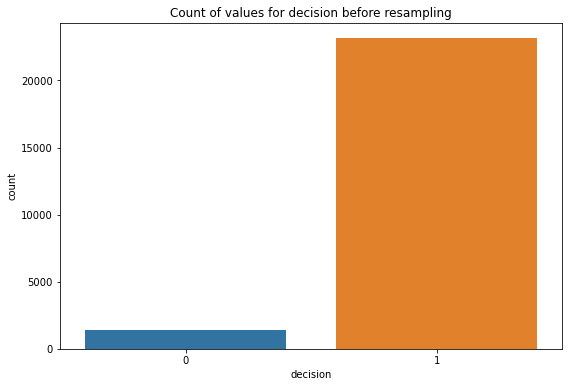

In [7]:
# plot the decision distribution
plt.figure(figsize=(9,6));
sns.countplot(x=train_y)
plt.title('Count of values for decision before resampling')

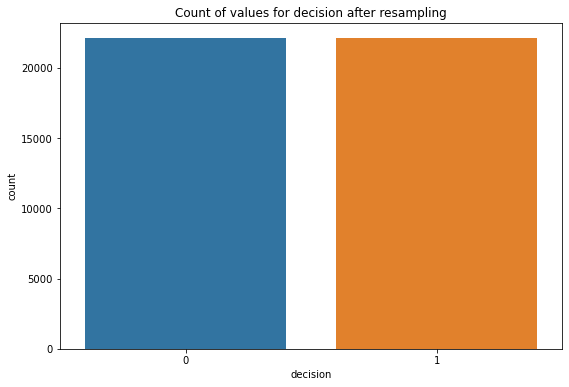

In [8]:
# plot the decision distribution after resampling
plt.figure(figsize=(9,6));
sns.countplot(x=resample_y)
plt.title('Count of values for decision after resampling');

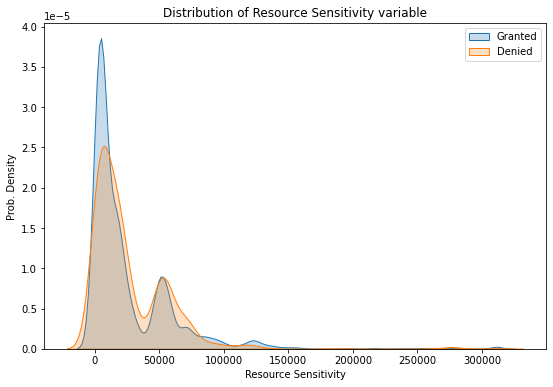

In [9]:
# Plot Resource sensitivity in relation to decision
plt.figure(figsize=(9,6));
sns.kdeplot(data=access_control_df.query('decision == 1')['resource_sensitivity'],label='Granted',shade=True)
sns.kdeplot(data=access_control_df.query('decision == 0')['resource_sensitivity'],label='Denied',shade=True)

plt.title('Distribution of Resource Sensitivity variable')
plt.xlabel('Resource Sensitivity')
plt.ylabel('Prob. Density')
plt.legend()

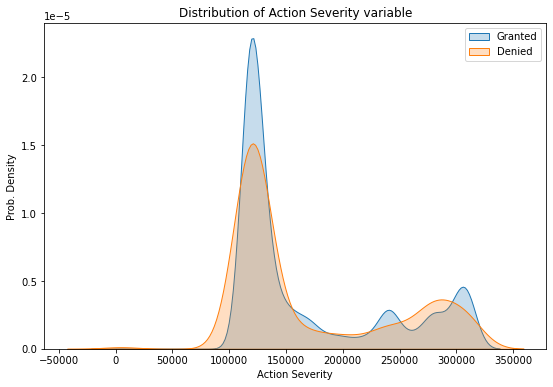

In [10]:
# Plot Action severity in relation to decision
plt.figure(figsize=(9,6));
sns.kdeplot(data=access_control_df.query('decision == 1')['action_severity'],label='Granted',shade=True)
sns.kdeplot(data=access_control_df.query('decision == 0')['action_severity'],label='Denied',shade=True)

plt.title('Distribution of Action Severity variable')
plt.xlabel('Action Severity')
plt.ylabel('Prob. Density')
plt.legend()

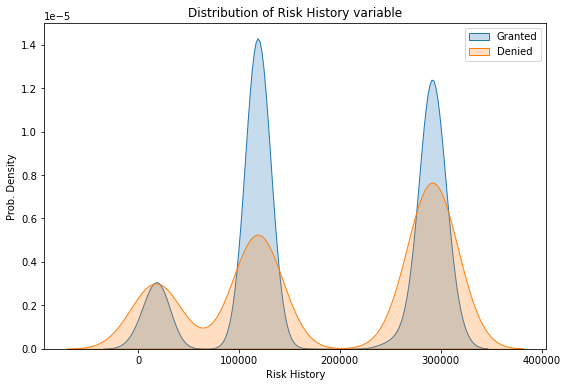

In [11]:
# Plot Risk History in relation to decision
plt.figure(figsize=(9,6));
sns.kdeplot(data=access_control_df.query('decision == 1')['risk_history'],label='Granted',shade=True)
sns.kdeplot(data=access_control_df.query('decision == 0')['risk_history'],label='Denied',shade=True)

plt.title('Distribution of Risk History variable')
plt.xlabel('Risk History')
plt.ylabel('Prob. Density')
plt.legend()

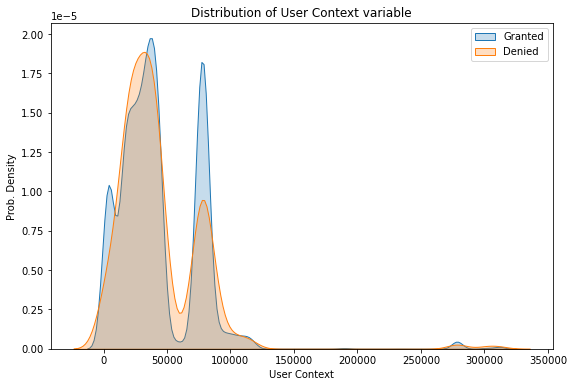

In [12]:
# Plot Resource sensitivity in relation to decision
plt.figure(figsize=(9,6));
sns.kdeplot(data=access_control_df.query('decision == 1')['user_context'],label='Granted',shade=True)
sns.kdeplot(data=access_control_df.query('decision == 0')['user_context'],label='Denied',shade=True)

plt.title('Distribution of User Context variable')
plt.xlabel('User Context')
plt.ylabel('Prob. Density')
plt.legend()

### Setup Experimentation
1. Make a function  for the proposed model
2. MAke a function of all the machine learning algorithms to use and evaluate
3. Make a function to evaluate the created models using metrics discussed in chapter 3
4. Collect and store the results of evaluation in a dataframe
5. Make visualizations of the scores of the metrics

In [13]:
# class ExportCatBoost:
#     def proposed_model(**kwargs):
#         """
#         Creates an instance of the proposed model with parameters
#         specified

#         Args:
#             model's key word arguments

#         Returns:
#             Cat Boost model instance
#         """
    
#         cat_boost_model  = cat.CatBoostClassifier(**kwargs)
    
#         return cat_boost_model
#     pass


def proposed_model(**kwargs):
    """
    Creates an instance of the proposed model with parameters
    specified

    Args:
        model's key word arguments

    Returns:
        Cat Boost model instance
    """
    
    cat_boost_model  = cat.CatBoostClassifier(**kwargs)
    
    return cat_boost_model

In [14]:
def get_models(**kwargs) -> Dict:
    """
    A function that returns a dictionary containing
    models to be used for training and evaluation
    
    Args:
        kwargs: keyword arguments for the proposed model

    Returns:
        ml_models: a dictionary of instantiated machine learning models
    """


    #get a list of models to evaluate
    ml_models = dict()
    ml_models['LR'] = LogisticRegression()
    ml_models['KNN'] = KNeighborsClassifier(n_neighbors=6)
    ml_models['Decision Tree'] = DecisionTreeClassifier()
    ml_models['SVM'] = SVC()
    ml_models['Naive Bayes'] = GaussianNB()
    ml_models['ANN'] = MLPClassifier()
    ml_models['Random Forest'] = RandomForestClassifier()
    ml_models['AdaBoost'] = AdaBoostClassifier()
    ml_models['Bagging'] = BaggingClassifier()
    ml_models['Proposed Model'] = proposed_model(**kwargs)

    return ml_models

In [15]:
def evaluate_model(algorithm, train_X, train_y, val_X, val_y) -> Dict:
    """
    Function which evaluates machine learning models and saves
    results in a dictionary

    Args:
        algorithm: machine learning algorithm instance
        train_X: features for training the algorithms
        train_y: target for training the algorithms
        val_X: data for validating/testing performance of the algorithms
        val_y: targets to be predicted

    Returns:
        results_dict: results dictionary
    """
    results_dict = {}	
    
    # fit an algorithm to the training data
    algorithm.fit(train_X, train_y)

    start_time = time.perf_counter()
    # make predictions on the validation data
    algorithm_predictions = algorithm.predict(val_X)
    end_time = time.perf_counter()

    # evaluate the performance of the predictions
    auc_roc = roc_auc_score(val_y, algorithm_predictions)
    f1_score_result = f1_score(val_y, algorithm_predictions)
    brier_score = brier_score_loss(val_y, algorithm_predictions)
    testing_time = end_time - start_time

    # save the results in a dictionary 
    results_dict['auc_roc'] = auc_roc
    results_dict['f1_score_result'] = f1_score_result
    results_dict['brier_score'] = brier_score
    results_dict['response_time'] = testing_time
    

    return results_dict


def perform_analysis(learner: Dict, train_X, train_y, val_X, val_y) -> Dict:
    """
    A function which performs fit and predict for machine learning
    models and returns their results

    Args:
        learner- machine learning model instance
        train_X: features for training the algorithms
        train_y: target for training the algorithms
        val_X: data for validating/testing performance of the algorithms
        val_y: targets to be predicted

    Returns
        results_dict: dictionary of results
    """

   
    results = {}
    # loop through algorithms in dictionary and evaluate them
    for name, algorithm in learner.items():
        scores = evaluate_model(algorithm, train_X, train_y, val_X, val_y)
    
        results[name]  = scores
        
    return results

In [16]:
def record_keeping(performances) -> DataFrame:
    """
    A function that does record keeping of the performances
    of each model

    Args:
        performances: a dictionary of algorithms and scores

    Returns:
        result_dataframe
    """
    
    auc_roc_dict = {}
    f1_score_dict = {}
    brier_dict = {}
    response_time_dict = {}

    # loop through dictionary to retrieve scores and store them in a dictionary
    for key, values in performances.items():
        
        f1_score_dict[key] = values['f1_score_result']
        auc_roc_dict[key] = values['auc_roc']
        brier_dict[key] = values['brier_score']
        response_time_dict[key] = values['response_time']
        
    result_frame = pd.DataFrame({   'F1 Score':f1_score_dict,
                                    'AUCROC':auc_roc_dict,
                                    'Brier Score': brier_dict,
                                    'Response Time': response_time_dict
                                    })
    return result_frame

In [17]:
# perform analysis
# enumerate the categorical features
cat_features = ['resource_sensitivity', 'action_severity', 'risk_history', 'user_context']

# instantiate the models to be analysed
models_for_analysis = get_models(depth=4, l2_leaf_reg=1, learning_rate=0.1,
cat_features=cat_features)

# perform the analysis
analysis_results = perform_analysis(models_for_analysis, resample_x, resample_y, Val_X, val_y)

# store the results of the analysis in a dataframe
analysis_results_df = record_keeping(analysis_results)

analysis_results_df


0:	learn: 0.5518777	total: 250ms	remaining: 4m 9s
1:	learn: 0.4643693	total: 310ms	remaining: 2m 34s
2:	learn: 0.3836984	total: 380ms	remaining: 2m 6s
3:	learn: 0.3151762	total: 450ms	remaining: 1m 52s
4:	learn: 0.2380873	total: 547ms	remaining: 1m 48s
5:	learn: 0.1917896	total: 651ms	remaining: 1m 47s
6:	learn: 0.1601731	total: 747ms	remaining: 1m 45s
7:	learn: 0.1368897	total: 843ms	remaining: 1m 44s
8:	learn: 0.1217669	total: 915ms	remaining: 1m 40s
9:	learn: 0.0907218	total: 1.07s	remaining: 1m 46s
10:	learn: 0.0722539	total: 1.2s	remaining: 1m 47s
11:	learn: 0.0605781	total: 1.32s	remaining: 1m 48s
12:	learn: 0.0529853	total: 1.42s	remaining: 1m 47s
13:	learn: 0.0478583	total: 1.67s	remaining: 1m 57s
14:	learn: 0.0443005	total: 1.75s	remaining: 1m 54s
15:	learn: 0.0395424	total: 1.83s	remaining: 1m 52s
16:	learn: 0.0365697	total: 1.93s	remaining: 1m 51s
17:	learn: 0.0346255	total: 2.03s	remaining: 1m 50s
18:	learn: 0.0327018	total: 2.12s	remaining: 1m 49s
19:	learn: 0.0313984	tota

,F1 Score,AUCROC,Brier Score,Response Time
LR,0.789260,0.491774,0.341999,0.001259
KNN,0.933254,0.554128,0.123764,0.319070
Decision Tree,0.958288,0.551900,0.079458,0.002172
SVM,0.756200,0.545043,0.381545,22.849345
Naive Bayes,0.641096,0.513616,0.511656,0.001645
ANN,0.962348,0.500148,0.072501,0.011745
Random Forest,0.963656,0.545201,0.069694,0.117980
AdaBoost,0.849192,0.542669,0.257293,0.041646
Bagging,0.957703,0.548347,0.080557,0.013853
Proposed Model,0.971598,0.547098,0.054925,0.026016


<AxesSubplot:xlabel='F1 Score'>

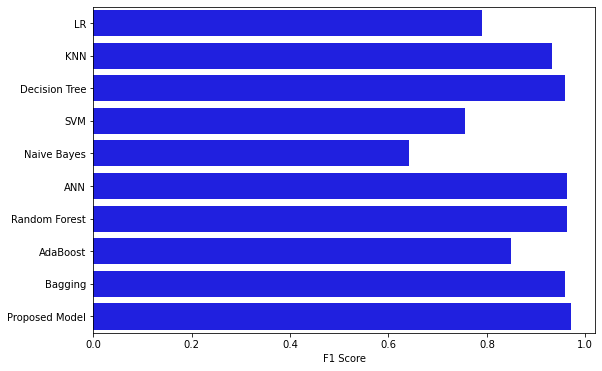

In [18]:
# plot AUCROC
plt.figure(figsize=(9,6));

sns.barplot(x="F1 Score", y=analysis_results_df.index, data=analysis_results_df, label="F1 Score", color="b")

Describe f1 Score.

The F1 plot shoes that there are four algorithms which have a similar performance in terms of f1 score. The proposed model, Random Forest, Bagging, ANN, Decision Tree all have an f1 score close to one, which shows that these algorithms are able to achieve a good balance between prescision and Recall, and thus be expected to not make many errors in classificationo or raise many false positives

<AxesSubplot:xlabel='AUCROC'>

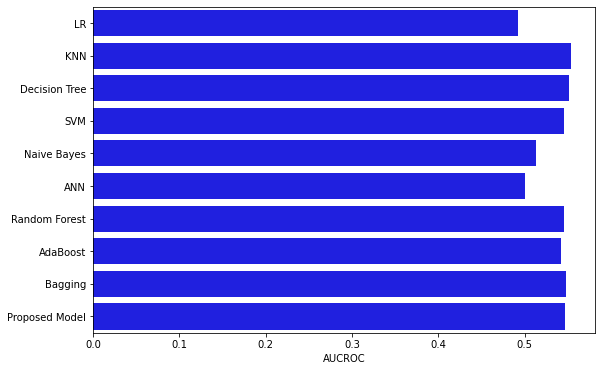

In [19]:
# plot AUCROC
plt.figure(figsize=(9,6));

sns.barplot(x="AUCROC", y=analysis_results_df.index, data=analysis_results_df, label="AUCROC", color="b")

Describe AUCROC.

This can definitely be improved upon as the AUCROC score of the proposed model is very close to 0.5 (0.55), which suggests that generally considering all probability thresholds, the model performs only slightly better than a random guess. Most of the machine learning models tested have a similar AUCROC, with the best model being KNN (0.55)

<AxesSubplot:xlabel='Brier Score'>

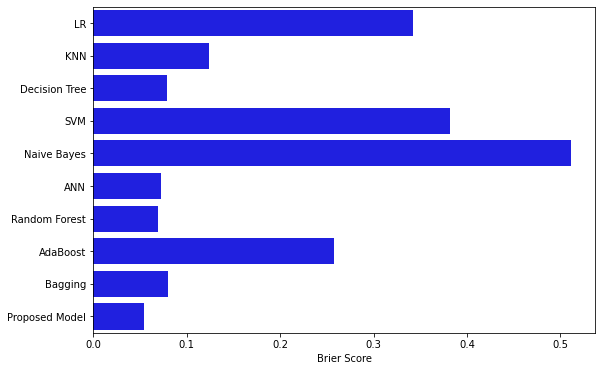

In [20]:
# plot Brier Score Loss
plt.figure(figsize=(9,6));

sns.barplot(x="Brier Score", y=analysis_results_df.index, data=analysis_results_df, label="Brier Score", color="b")

Describe Brier Score loss

The plot shows that the proposed model achieves the smallest loss as compared to the other algorithms evaluated. This shows us that the model is more confident in it's predictions of the class probabilities when compared to the other models.

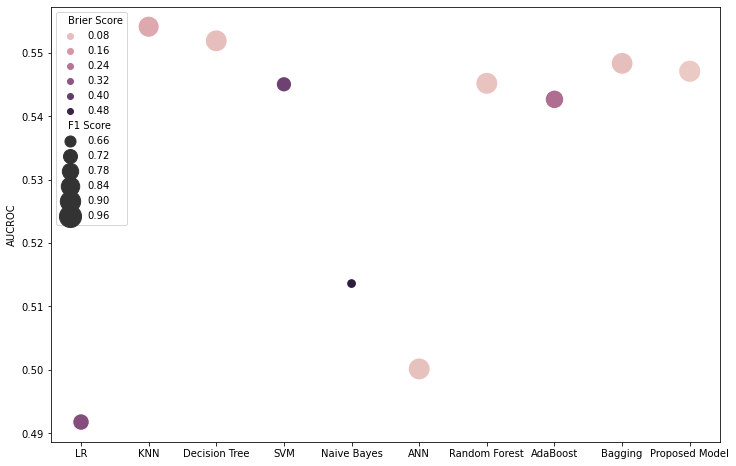

In [21]:
plt.figure(figsize=(12,8));
sns.scatterplot(data=analysis_results_df, x=analysis_results_df.index, y="AUCROC", hue='Brier Score', hue_norm=(0.04, 0.5), size='F1 Score', sizes=(100, 500))
plt.show()

In [23]:
export_model = proposed_model(depth=4, 
                            l2_leaf_reg=1, 
                            learning_rate=0.1,
                            cat_features=cat_features)

export_model.fit(resample_x, resample_y)

export_model.save_model("proposed_model")

0:	learn: 0.5518777	total: 64ms	remaining: 1m 3s
1:	learn: 0.4643693	total: 127ms	remaining: 1m 3s
2:	learn: 0.3836984	total: 194ms	remaining: 1m 4s
3:	learn: 0.3151762	total: 284ms	remaining: 1m 10s
4:	learn: 0.2380873	total: 343ms	remaining: 1m 8s
5:	learn: 0.1917896	total: 408ms	remaining: 1m 7s
6:	learn: 0.1601731	total: 463ms	remaining: 1m 5s
7:	learn: 0.1368897	total: 518ms	remaining: 1m 4s
8:	learn: 0.1217669	total: 587ms	remaining: 1m 4s
9:	learn: 0.0907218	total: 646ms	remaining: 1m 3s
10:	learn: 0.0722539	total: 721ms	remaining: 1m 4s
11:	learn: 0.0605781	total: 805ms	remaining: 1m 6s
12:	learn: 0.0529853	total: 880ms	remaining: 1m 6s
13:	learn: 0.0478583	total: 936ms	remaining: 1m 5s
14:	learn: 0.0443005	total: 987ms	remaining: 1m 4s
15:	learn: 0.0395424	total: 1.04s	remaining: 1m 4s
16:	learn: 0.0365697	total: 1.1s	remaining: 1m 3s
17:	learn: 0.0346255	total: 1.15s	remaining: 1m 2s
18:	learn: 0.0327018	total: 1.21s	remaining: 1m 2s
19:	learn: 0.0313984	total: 1.26s	remainin